**I want to build a simple keyword-based news classification model using the short_description field of news articles,
 So that I can evaluate how well frequent words alone can classify articles into four categories.**

# **1. Dataset Preparation**

1.1. Use the Kaggle News Category Dataset.

2.1. Keep only the categories: POLITICS, TRAVEL, SPORTS, HOME & LIVING.

3.1. Select 1000 samples per category (total 4000).

4.1. Retain only the short_description column and corrxesponding label.

5.1. Perform an 80/20 stratified split into train and test sets.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer  # <-- this is required
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import re

In [2]:
# Load dataset
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)
df.shape
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [4]:
categories = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
df_filtered = df[df["category"].isin(categories)]
df_filtered["category"].value_counts()

category
POLITICS         35602
TRAVEL            9900
SPORTS            5077
HOME & LIVING     4320
Name: count, dtype: int64

In [5]:
df_samples = (df_filtered.groupby("category", group_keys=False).sample(n=1000, random_state=42))
df_samples["category"].value_counts()

category
HOME & LIVING    1000
POLITICS         1000
SPORTS           1000
TRAVEL           1000
Name: count, dtype: int64

In [6]:
df_samples.shape

(4000, 6)

In [7]:
# Stratified 80/20 split
train_df, test_df = train_test_split(
    df_samples, test_size=0.2, stratify=df_samples['category'], random_state=42
)

In [8]:
train_df

,link,headline,category,short_description,authors,date
103628,https://www.huffingtonpost.com/entry/hanging-o...,Hanging Out in Hanging Lake (Colorado Rocky Mo...,TRAVEL,Since both my friend and I are avid photograph...,"Heather Hummel, ContributorPhotojournalist, Pr...",2015-03-30
3287,https://www.huffpost.com/entry/nfl-interviews-...,More Minorities Got Interviews For NFL Jobs. B...,SPORTS,Only two of the seven head coaching jobs that ...,,2021-01-30
144196,https://www.huffingtonpost.com/entry/sports-ni...,"Peyton Manning, Jason Collins, Jack Hoffman He...",SPORTS,"To paraphrase a certain North Pole resident, t...",Chris Greenberg,2013-12-25
183264,https://www.huffingtonpost.com/entry/tiny-hous...,House Tour: Author And Blogger Tammy Strobel S...,HOME & LIVING,"This writer did it, and so can you.",Amy Marturana,2012-11-06
132866,https://www.huffingtonpost.com/entry/in-poores...,Anti-Obamacare Campaigns Cause Serious Harm To...,POLITICS,,,2014-04-27
...,...,...,...,...,...,...
189638,https://www.huffingtonpost.com/entry/my-journe...,My Journey Home: Reflections On The Vietnamese...,TRAVEL,Eight years a PBS film crew in a TV series cal...,"Andrew Lam, Contributor\nAuthor",2012-08-29
204772,https://www.huffingtonpost.com/entry/rick-stev...,Rick Steves' Road Trip: Des Moines Honors Food...,TRAVEL,The building is really as sumptuous and filled...,"Rick Steves, Contributor\nContributor",2012-03-19
43846,https://www.huffingtonpost.com/entry/mondays-m...,Monday's Morning Email: Tom Brady Delivers Sup...,POLITICS,And the first Super Bowl overtime.,Lauren Weber,2017-02-06
94937,https://www.huffingtonpost.com/entry/datone-jo...,Datone Jones Bought Some Marijuana Just Hours ...,SPORTS,The offseason is smoking season for a lot of N...,Justin Block,2015-07-07


In [9]:
test_df

,link,headline,category,short_description,authors,date
1770,https://www.huffpost.com/entry/real-christmas-...,Getting A Real Christmas Tree This Year? Here'...,HOME & LIVING,Here's what experts have to say about potentia...,Caroline Bologna,2021-10-26
70986,https://www.huffingtonpost.com/entry/tim-canov...,Obama's Endorsement Of Debbie Wasserman Schult...,POLITICS,Tim Canova raised more than half a million dol...,Amanda Terkel,2016-04-04
176609,https://www.huffingtonpost.com/entry/amanda-wa...,Amanda Warrington Glues Giant Puzzle To Her Li...,HOME & LIVING,"And it only took her 1,000 hours to complete it.",Michelle Manetti,2013-01-17
2801,https://www.huffpost.com/entry/trump-defense-r...,Trump Launches Scathing Attack On Rudy Giulian...,POLITICS,"Trump called his former personal attorney, who...",Mary Papenfuss,2021-04-30
144599,https://www.huffingtonpost.com/entry/christmas...,What Your Christmas Decor Says About You (PHOTOS),HOME & LIVING,There's nothing like spending the holidays wit...,Jessica Cumberbatch Anderson,2013-12-20
...,...,...,...,...,...,...
161317,https://www.huffingtonpost.com/entry/angela-li...,"Angela Lindvall, Model, Has A Home That's As E...",HOME & LIVING,Girl's got a classic Yurt in her backyard -- c...,Michelle Manetti,2013-06-27
26515,https://www.huffingtonpost.com/entry/hurricane...,Hurricane Harvey And The Potential Hypocrisy O...,POLITICS,They opposed aid for victims of Hurricane Sand...,Matt Fuller and Kaeli Subberwal,2017-08-28
129159,https://www.huffingtonpost.com/entry/sicily-wi...,"Sicily! Wine, Culinary & Cultural Explorations...",TRAVEL,As we clinked glasses of Nero d'Avola and gobb...,"Stefani Jackenthal, ContributorAdventure Trave...",2014-06-11
172954,https://www.huffingtonpost.com/entry/creating-...,Creating a Home Together Is an Intimate Act: 4...,HOME & LIVING,"Sir Winston Churchill once said, ""... we shape...","Sharon O'Neill, Contributor\nMarriage and Fami...",2013-02-24


# **2. Word Frequency & Word Cloud**

2.1. Generate word clouds from the short_description texts in the training set for each category.

2.2. Extract the most frequent words per category.

2.3. Save these into category-specific sets.

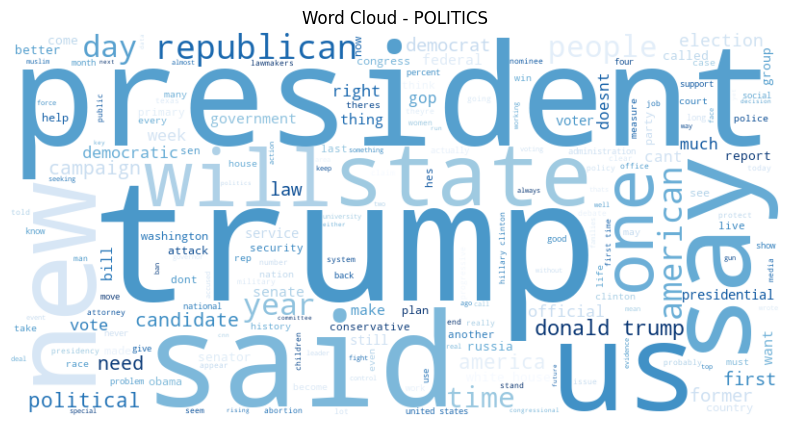

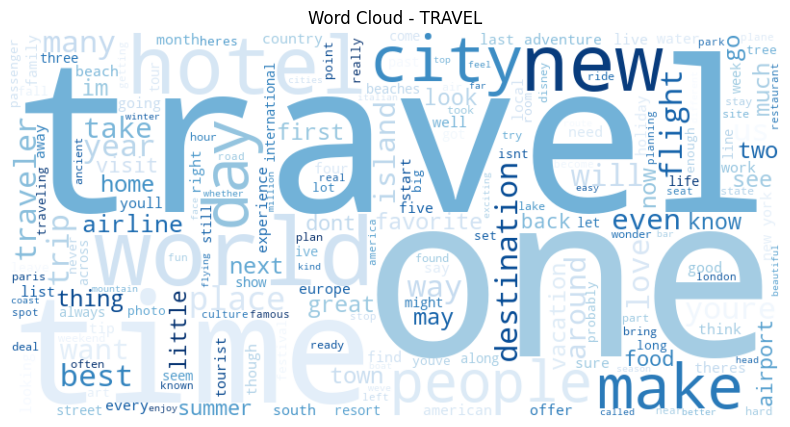

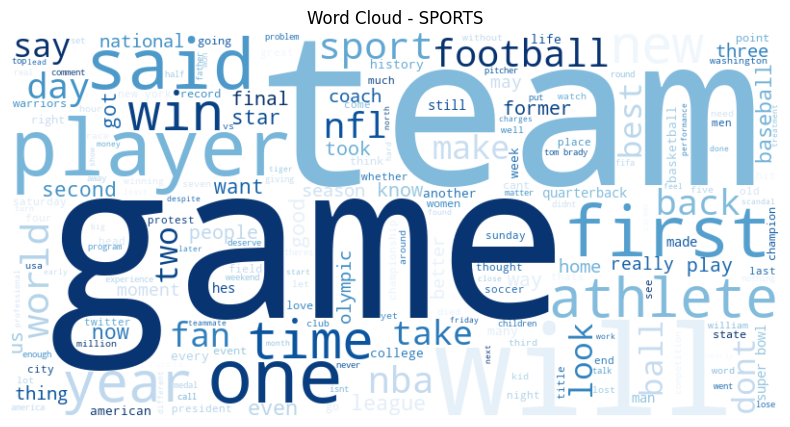

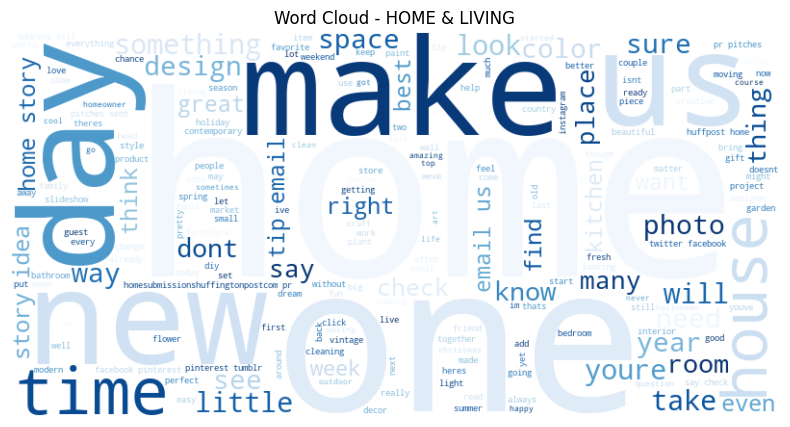

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

category_words = {}

for cat in categories:
    # Combine all short_description texts for this category
    text = " ".join(train_df[train_df['category'] == cat]['short_description'].apply(clean_text))
    
    # Generate and show word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='Blues').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {cat}")
    plt.show()
    
    # Save top frequent words
    words = text.split()
    most_common = [w for w, _ in Counter(words).most_common(50)]
    category_words[cat] = set(most_common)


In [11]:
category_corpus = {}
for cat in categories:
    text = " ".join(train_df[train_df['category']==cat]['short_description'].apply(clean_text))
    category_corpus[cat] = text

In [12]:
category_words = {}
for cat in categories:
    vectorizer = TfidfVectorizer(max_features=200, ngram_range=(1,2), stop_words='english')
    vectorizer.fit([category_corpus[cat]])
    category_words[cat] = set(vectorizer.get_feature_names_out())

# **3. Classification Approach**

3.1. Classify test samples based on the presence of frequent words in their short_description.

3.2. Start with top 10 frequent words per category.

3.3. Increase to 20, 30, 50… words and compare results.

In [13]:
def classify_by_keywords(description, category_words, top_n_words=None):
    words = set(clean_text(description).split())
    scores = {}
    for cat, freq_words in category_words.items():
        selected_words = set(list(freq_words)[:top_n_words]) if top_n_words else freq_words
        scores[cat] = len(words & selected_words)
    
    max_score = max(scores.values())
    top_categories = [cat for cat, score in scores.items() if score == max_score]
        # Randomly choose among ties or no overlap
    return random.choice(top_categories)

In [14]:
import random

def classify_by_keywords(description, category_words, top_n_words=None):
    words = set(clean_text(description).split())
    scores = {}

    print("Top words considered per category:")
    for cat, freq_words in category_words.items():
        selected_words = set(list(freq_words)[:top_n_words]) if top_n_words else freq_words
        print(f"{cat} ({len(selected_words)} words): {list(selected_words)[:10]} ...")  # show first 10 words
        scores[cat] = len(words & selected_words)
    
    max_score = max(scores.values())
    top_categories = [cat for cat, score in scores.items() if score == max_score]
    
    predicted_category = random.choice(top_categories) if top_categories else "unknown"
    return predicted_category


# **4. Evaluation**

4.1. Compute performance using accuracy.
    
4.2. Compare how classification improves (or not) as more frequent words are used.

In [15]:
top_words_list = [10, 20, 50, 100, 200]
results = {}

for top_n in top_words_list:
    predictions = test_df['short_description'].apply(lambda x: classify_by_keywords(x, category_words, top_n_words=top_n))
    accuracy = (predictions == test_df['category']).mean()
    results[top_n] = accuracy
    print(f"Top-{top_n} words accuracy: {accuracy:.4f}")


Top words considered per category:
POLITICS (10 words): ['control', 'donald trumps', 'monday', 'voters', 'like', 'wrote', 'military', 'american', 'hes', 'sunday'] ...
TRAVEL (10 words): ['national', 'weekend', 'different', 'places', 'beach', 'heres', 'like', 'american', 'great', 'place'] ...
SPORTS (10 words): ['weekend', '2015', 'teams', 'different', 'million', 'like', 'field', 'american', 'great', 'hes'] ...
HOME & LIVING (10 words): ['weekend', 'scroll', 'gifts', 'add', 'heres', 'like', 'space', 'plants', 'click', 'great'] ...
Top words considered per category:
POLITICS (10 words): ['control', 'donald trumps', 'monday', 'voters', 'like', 'wrote', 'military', 'american', 'hes', 'sunday'] ...
TRAVEL (10 words): ['national', 'weekend', 'different', 'places', 'beach', 'heres', 'like', 'american', 'great', 'place'] ...
SPORTS (10 words): ['weekend', '2015', 'teams', 'different', 'million', 'like', 'field', 'american', 'great', 'hes'] ...
HOME & LIVING (10 words): ['weekend', 'scroll', 'g

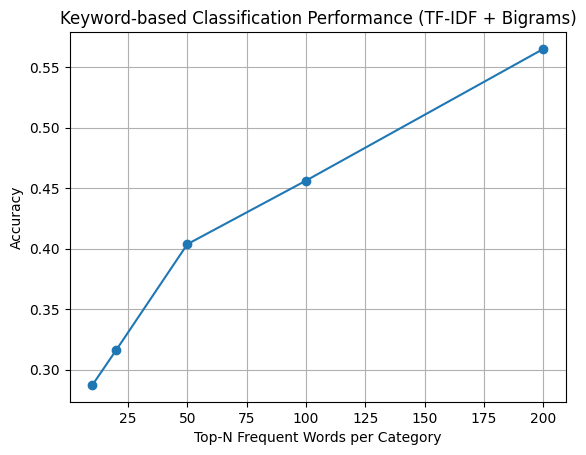

In [16]:
plt.plot(list(results.keys()), list(results.values()), marker="o")
plt.xlabel("Top-N Frequent Words per Category")
plt.ylabel("Accuracy")
plt.title("Keyword-based Classification Performance (TF-IDF + Bigrams)")
plt.grid(True)
plt.show()